In [58]:
import pandas as pd
import numpy as np
from shapely import geometry
from shapely.ops import cascaded_union
import os

In [59]:
data_folder = r'D:\Pu\20211230-P_brain_M1_nonclear'
contour_filename = os.path.join(data_folder, r'contour_3.txt')
# read position file
if os.path.exists(contour_filename):
    points = pd.read_csv(contour_filename, header=None, sep=',')
points.columns=['X', 'Y']
points

,X,Y
0,6141.68,-107.35
1,6456.05,-176.35
2,6743.58,-287.53
3,7349.32,-371.87
4,7518.00,-364.21
5,7548.67,0.00
6,7560.17,283.70
7,7564.01,544.39
8,7544.84,743.75
9,6942.94,590.40


In [60]:
# convert into polygon
grid_size = 200 # um

tissue = geometry.Polygon(points.values)

grid_center = np.round(np.array(tissue.centroid.coords)[0], 1)

grid_inds = [np.arange(np.floor( (np.min(points['X'])-grid_center[0])/grid_size ), 
                      np.ceil( (max(points['X'])-grid_center[0])/grid_size )+1 ),
             np.arange(np.floor( (np.min(points['Y'])-grid_center[1])/grid_size ), 
                      np.ceil( (max(points['Y'])-grid_center[1])/grid_size )+1 ),
            ]
                
grids = np.array(np.meshgrid(*grid_inds))#.reshape(len(grid_inds),-1).transpose()
# generate tiles in snake style

sorted_grids = []
for _iy in np.arange(grids.shape[-1]):
    _line_grids = grids[:,:,_iy]
    if _iy % 2 == 0:
        sorted_grids.append(_line_grids)
    else:
        sorted_grids.append(np.fliplr(_line_grids))
        
grids = np.concatenate(sorted_grids, axis=1).transpose()

In [61]:
positions = []

for _i, _grid in enumerate(grids):
    _grid_position = _grid * grid_size + grid_center
    #print(_grid_position)
    # get each grid point
    _grid_point = geometry.Point(_grid_position)
    _fov_shape = geometry.Polygon([
            _grid_position + [-grid_size/2, -grid_size/2], 
            _grid_position + [grid_size/2, -grid_size/2], 
            _grid_position + [grid_size/2, grid_size/2], 
            _grid_position + [-grid_size/2, grid_size/2], 
        ])
    # calculate intersect
    _intersect = _fov_shape.intersection(tissue)
    if _intersect.area > 0:
        positions.append(_grid_position)
        
positions = np.array(positions)
print(np.shape(positions))

(46, 2)


## Plot

In [62]:
#positions[54]

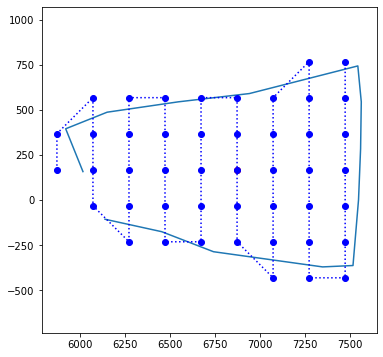

46


In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(points['X'], points['Y'])
plt.axis('equal')
plt.plot(grid_center[0], grid_center[1], 'ro')
#plt.axes('equal')
plt.plot(positions[:,0], positions[:,1], 'b:o')

plt.show()

print(len(positions))

## Save

In [64]:
overwrite = False
save_filename = contour_filename.replace('.txt', '_positions.txt')

if os.path.exists(save_filename) and not overwrite:
    print(f"file: {save_filename} already exist, skip!")
else:
    print(f"save {len(positions)} coordinates into file: {save_filename}")
    np.savetxt(save_filename, np.round(positions,2), delimiter=',', fmt='%.2f')

save 46 coordinates into file: D:\Pu\20211230-P_brain_M1_nonclear\contour_3_positions.txt
